In [1]:
import pandas as pd
from PIL import Image
import numpy as np
from matplotlib import *
from matplotlib import pyplot
from matplotlib import colors
from scipy.stats import *
from sklearn import *
import os.path
import custom_distance_workers
from multiprocessing import Pool

In [2]:
data=pd.read_csv('dataset.csv', delimiter=';', dtype={'id':str, 'label':str})
folder='Raw/prostata-fases-base'
data.head()

,id,label
0,ProstateX-0183-Class-3-patch.tif,cancer
1,ProstateX-0139-Class-2-patch.tif,cancer
2,ProstateX-0191-Class-1-patch.tif,cancer
3,ProstateX-0198-Class-5-patch.tif,cancer
4,ProstateX-0184-Class-3-patch.tif,cancer


In [3]:
data[['id','label']].values

array([['ProstateX-0183-Class-3-patch.tif', 'cancer'],
       ['ProstateX-0139-Class-2-patch.tif', 'cancer'],
       ['ProstateX-0191-Class-1-patch.tif', 'cancer'],
       ['ProstateX-0198-Class-5-patch.tif', 'cancer'],
       ['ProstateX-0184-Class-3-patch.tif', 'cancer'],
       ['ProstateX-0173-Class-1-patch.tif', 'cancer'],
       ['ProstateX-0026-Class-4-patch.tif', 'cancer'],
       ['ProstateX-0104-Class-2-patch.tif', 'cancer'],
       ['ProstateX-0018-Class-2-patch.tif', 'cancer'],
       ['ProstateX-0001-Class-1-patch.tif', 'cancer'],
       ['ProstateX-0014-Class-2-patch.tif', 'cancer'],
       ['ProstateX-0181-Class-5-patch.tif', 'cancer'],
       ['ProstateX-0037-Class-2-patch.tif', 'cancer'],
       ['ProstateX-0203-Class-3-patch.tif', 'cancer'],
       ['ProstateX-0095-Class-3-patch.tif', 'cancer'],
       ['ProstateX-0103-Class-5-patch.tif', 'cancer'],
       ['ProstateX-0102-Class-2-patch.tif', 'cancer'],
       ['ProstateX-0077-Class-4-patch.tif', 'cancer'],
       ['P

In [4]:
def open_image_dataset(init_folder, image_file, label):
    return np.asarray(Image.open(init_folder+'/'+label+'/'+image_file).convert('L'))

In [5]:
def get_phase_img(image, mode):
    fourier_img=np.fft.fftshift(np.fft.fft2(image))
    phase=np.angle(fourier_img)
    if mode=='linear':
        return phase_to_linear(phase_two_pi(phase))
    elif mode=='two-pi':
        return phase_two_pi(phase)
    elif mode=='normal':
        return phase
    else:
        return 0

In [6]:
def get_fourier_transform_mag_pha(image):
    fourier_img=np.fft.fftshift(np.fft.fft2(image))
    return [np.abs(fourier_img), np.angle(fourier_img)]

In [7]:
def fourier_inverse_from_polar(polars):
    [magnitude, phase]=[polars[0], polars[1]]
    carts = magnitude*np.cos(phase) + (1j)*magnitude*np.sin(phase)
    return np.abs(np.fft.ifft2(np.fft.fftshift(carts)))

In [8]:
images=[open_image_dataset(folder, row[0], row[1]) for row in data[['id','label']].values]

In [9]:
def distance_metric(A,B):
    dim=len(A)
    k=1/(dim**2)
    return k*np.linalg.norm(np.abs(A-B))

In [10]:
def get_tiles_image(image, m, n):
    size=np.shape(image)
    return image.reshape(int(size[0]/m),m,-1,n).swapaxes(2,1).reshape(-1, m*n)

In [11]:
def get_image_from_tiles(tiles, m, n, u, v):
    return tiles.reshape(-1,u,v).reshape(int(m/u),-1,u,v).swapaxes(1,2).reshape(m,n)

In [12]:
def get_feature_matrix_patches(images, m, n):
    size=np.shape(images[0])
    count=0
    for image in images:
        tiles=image.reshape(int(size[0]/m),m,-1,n).swapaxes(2,1).reshape(-1, m*n)
        if count==0:
            features=tiles
        else:
            features=np.append(features,tiles,axis=0)
        count+=1
    return features

In [13]:
def precompute_metric(feature_matrix):
    subs=np.shape(feature_matrix)[0]
    metric_matrix=np.zeros((subs,subs))
    print('corriendo matriz de distancias')
    for i in range(subs):
        for j in range(subs):
            metric_matrix[i,j]=distance_metric(feature_matrix[i,:],feature_matrix[j,:])
    print('matriz de distancias OK')
    return metric_matrix
            

In [14]:
def set_k_clustering(precomputed_distance, feature_matrix):
    p_val=0
    k=1
    while p_val<0.97:
        clustering_model=cluster.AgglomerativeClustering(n_clusters=k, linkage='average', affinity="precomputed").fit(precomputed_distance)
        labels=clustering_model.labels_
        p_values=[]
        p_p_val=[]
        N = np.shape(feature_matrix)[0]
        for i in range(k):
            features_cluster=feature_matrix[np.where(labels==i),:].reshape(-1)
            try: 
                kurt,p=normaltest(features_cluster)
                p_values.append(p)
                p_p_val.append(np.shape(feature_matrix[np.where(labels==i)])[0]/N)
            except:
                continue 
        #p_val=np.sum(np.multiply(p_values, p_p_val))
        p_val=np.max(p_values)
        print('K: '+str(k)+', p-val: '+str(p_val))
        #print(p_values)
        #print(p_p_val)
        k+=1
    return k

In [15]:
phases_all=[]
#primero va healthy, luego cancer
for label in pd.unique(data.label):
    data_q=data[data.label==label]
    images_q=[open_image_dataset(folder, row[0], row[1]) for row in data_q[['id', 'label']].values]
    phases_q=[get_fourier_transform_mag_pha(image)[1] for image in images_q]    
    tile_k=5
    clustering_features=get_feature_matrix_patches(phases_q, tile_k, tile_k)
    if __name__ ==  '__main__': 
        num_processes=20
        p=Pool()
        metric_params=[[clustering_features[row_a,:],clustering_features[row_b,:]] 
                       for row_a,_ in enumerate(clustering_features) for row_b, _ in enumerate(clustering_features)]
        distance_row=p.map(custom_distance_workers.single_fill, metric_params)
    distance_matrix=np.reshape(distance_row, [np.shape(clustering_features)[0], np.shape(clustering_features)[0]]) 
        
    #distance_matrix=precompute_metric(clustering_features)
    k = set_k_clustering(distance_matrix, clustering_features)

K: 1, p-val: 0.0
K: 2, p-val: 8.132142357621559e-17
K: 3, p-val: 2.023214529263648e-05
K: 4, p-val: 0.043787200074261116
K: 5, p-val: 0.043787200074261116
K: 6, p-val: 0.043787200074261116
K: 7, p-val: 0.043787200074261116
K: 8, p-val: 0.043787200074261116
K: 9, p-val: 0.043787200074261116
K: 10, p-val: 0.043787200074261116
K: 11, p-val: 0.043787200074261116
K: 12, p-val: 0.043787200074261116
K: 13, p-val: 0.043787200074261116
K: 14, p-val: 0.043787200074261116
K: 15, p-val: 0.043787200074261116
K: 16, p-val: 0.043787200074261116
K: 17, p-val: 0.043787200074261116
K: 18, p-val: 0.043787200074261116
K: 19, p-val: 0.043787200074261116
K: 20, p-val: 0.043787200074261116
K: 21, p-val: 0.043787200074261116
K: 22, p-val: 0.043787200074261116
K: 23, p-val: 0.043787200074261116
K: 24, p-val: 0.043787200074261116
K: 25, p-val: 0.043787200074261116
K: 26, p-val: 0.043787200074261116
K: 27, p-val: 0.043787200074261116
K: 28, p-val: 0.043787200074261116
K: 29, p-val: 0.043787200074261116
K: 30, p-

KeyboardInterrupt: 

0.02044365603605174


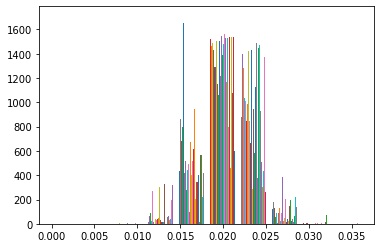

In [16]:
print(np.mean(distance_matrix))

pyplot.hist(distance_matrix)
pyplot.show()

In [37]:
z=[[1,2,3,4],[5,6,7,8]]
m = [[row_a,row_b] for row_a,rows_b in enumerate(z) for row_b in rows_b]

mo = [[row_a, row_b] for row_a, _ in enumerate(z) for row_b, _ in enumerate(z)]
print(mo)

[[0, 0], [0, 1], [1, 0], [1, 1]]


In [47]:
metric_params

[[array([ 3.14159265,  0.34794752, -0.94501218, -0.02473025,  0.7631927 ,
          0.32005771, -0.95405147,  0.41579387,  0.02788217, -1.70369328,
         -0.17575915,  0.94665358,  0.61733942, -0.28121759, -0.76837605,
          2.49393851,  2.38921135,  3.01247105, -0.80251323, -0.767672  ,
          0.45780727, -1.22516247,  0.51681822,  0.39576788,  1.6318611 ]),
  array([-1.64468085, -0.00474717,  0.75744071,  2.45230952,  0.16690899,
         -1.56072054, -0.17280996,  1.12986474, -2.87343396, -0.2751584 ,
         -0.26278656,  0.97114357,  1.01369035, -2.90423289,  0.26996336,
          2.37432514,  0.76870044,  1.21475157,  2.85318413, -1.79939444,
          1.01383651, -1.03010818,  0.97626229,  0.28861078,  0.68604125])],
 [array([ 3.14159265,  0.34794752, -0.94501218, -0.02473025,  0.7631927 ,
          0.32005771, -0.95405147,  0.41579387,  0.02788217, -1.70369328,
         -0.17575915,  0.94665358,  0.61733942, -0.28121759, -0.76837605,
          2.49393851,  2.38921135

In [34]:
np.shape(clustering_features)
[[row,col] for row,cols in enumerate(clustering_features) for col, _ in enumerate(cols)]
#[[clustering_features[row_a,:],clustering_features[row_b,:]] for row_a,rows_b in enumerate(z) for row_b in rows_b]

[[0, 0],
 [0, 1],
 [0, 2],
 [0, 3],
 [0, 4],
 [0, 5],
 [0, 6],
 [0, 7],
 [0, 8],
 [0, 9],
 [0, 10],
 [0, 11],
 [0, 12],
 [0, 13],
 [0, 14],
 [0, 15],
 [0, 16],
 [0, 17],
 [0, 18],
 [0, 19],
 [0, 20],
 [0, 21],
 [0, 22],
 [0, 23],
 [0, 24],
 [1, 0],
 [1, 1],
 [1, 2],
 [1, 3],
 [1, 4],
 [1, 5],
 [1, 6],
 [1, 7],
 [1, 8],
 [1, 9],
 [1, 10],
 [1, 11],
 [1, 12],
 [1, 13],
 [1, 14],
 [1, 15],
 [1, 16],
 [1, 17],
 [1, 18],
 [1, 19],
 [1, 20],
 [1, 21],
 [1, 22],
 [1, 23],
 [1, 24],
 [2, 0],
 [2, 1],
 [2, 2],
 [2, 3],
 [2, 4],
 [2, 5],
 [2, 6],
 [2, 7],
 [2, 8],
 [2, 9],
 [2, 10],
 [2, 11],
 [2, 12],
 [2, 13],
 [2, 14],
 [2, 15],
 [2, 16],
 [2, 17],
 [2, 18],
 [2, 19],
 [2, 20],
 [2, 21],
 [2, 22],
 [2, 23],
 [2, 24],
 [3, 0],
 [3, 1],
 [3, 2],
 [3, 3],
 [3, 4],
 [3, 5],
 [3, 6],
 [3, 7],
 [3, 8],
 [3, 9],
 [3, 10],
 [3, 11],
 [3, 12],
 [3, 13],
 [3, 14],
 [3, 15],
 [3, 16],
 [3, 17],
 [3, 18],
 [3, 19],
 [3, 20],
 [3, 21],
 [3, 22],
 [3, 23],
 [3, 24],
 [4, 0],
 [4, 1],
 [4, 2],
 [4, 3],
 [4,

In [16]:
distance_matrix

array([[0.        , 0.01407882, 0.01616419, ..., 0.02152466, 0.01844368,
        0.01735475],
       [0.01407882, 0.        , 0.01564621, ..., 0.02172828, 0.01767276,
        0.01625178],
       [0.01616419, 0.01564621, 0.        , ..., 0.02393396, 0.02195473,
        0.02115048],
       ...,
       [0.02152466, 0.02172828, 0.02393396, ..., 0.        , 0.0210882 ,
        0.01435103],
       [0.01844368, 0.01767276, 0.02195473, ..., 0.0210882 , 0.        ,
        0.01601992],
       [0.01735475, 0.01625178, 0.02115048, ..., 0.01435103, 0.01601992,
        0.        ]])